In [377]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import re

# 1. Load data

In [378]:
# df = pd.read_csv('data/Activities_2023_VietAnh.csv')
# date_format = '%m/%d/%y'
# time_format = '%I:%M:%S %p'

df = pd.read_csv('data/phone_usage.csv')
date_format = '%d/%m/%Y'
time_format = '%H:%M:%S'


df = df.dropna() #Recent actions that not end yet

df['Date'] = pd.to_datetime(df['Date'], format= date_format)
df['Time'] = pd.to_datetime(df['Time'], format= time_format)
df['Time'] = df['Time'].dt.time
def time_to_seconds(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    return hours * 3600 + minutes * 60 + seconds

df['Duration'] = df['Duration'].apply(time_to_seconds)


# Transformation a bit on data:
## 1. Merge Screen off (locked/unlocked) on the App name field & Delete all the Screen on instances
df = df[~df['App name'].str.contains('Screen on')]

df['App name'] = df['App name'].replace({'Screen off (unlocked)': 'Screen off', 'Screen off (locked)': 'Screen off'})


## 2. Eliminate all the action that has duration less than 1 
df = df[df['Duration'] > 1]

## 3. Merge a few stuffs:

## 3.1. All Amazone services -> Merge into Amazon
df['App name'] = df['App name'].replace({'Amazon Web Services': 'Amazon', 'Amazon Prime Video': 'Amazon',
                                         'Amazon Shopping': 'Amazon', 'Amazon Music': 'Amazon',
                                         'Amazon Kindle': 'Amazon', 'redBus': 'Amazon'})

df['App name'] = df['App name'].replace({'Flipkart': 'Amazon'}) #Online buying platform

## 3.2 Merge Opera mini with Chrome (as Navigator)
df['App name'] = df['App name'].replace({'Opera Mini': 'Chrome', 'Opera': 'Chrome',
                                         'Google': 'Chrome'})

## 3.3 Name of Hotstar -> Disney+
df['App name'] = df['App name'].replace({'Hotstar': 'Disney Plus', 'MX Player': 'Disney Plus',
                                         'Video Player': 'Disney Plus'})

## 3.4 Drop Device Boot/ Device Shutdown

df = df[~df['App name'].str.contains('Device')]

## 3.5 Merge Swiggy (Indian food delivery service) with Uber Eats
df['App name'] = df['App name'].replace({'Swiggy': 'Food-delivery Apps', 'Uber Eats': 'Food-delivery Apps'})

## 3.6 Delete unknown apps :
non_english_pattern = re.compile(r'[^\x00-\x7F]+')
df = df[~df['App name'].str.contains(non_english_pattern)]

## 3.7 Merge some games
df['App name'] = df['App name'].replace({'PUBG MOBILE LITE': 'Games Apps', 'Call of Duty': 'Games Apps',\
                                         'Crossword': 'Games Apps'})

## 3.8 Merge Google services:
df['App name'] = df['App name'].replace({'Google Pay': 'Google Services', 'Google Play Store': 'Google Services',
                                        'Drive': 'Google Services', 'Gmail': 'Google Services'})

## 3.9 Merge Messages & Telegram into WhatsApp:
df['App name'] = df['App name'].replace({'Messages': 'WhatsApp', 'Telegram': 'WhatsApp'})

## 3.10 Merge Camera into Galery:
df['App name'] = df['App name'].replace({'Camera': 'Gallery'})

## 3.11 Merge learning apps

df['App name'] = df['App name'].replace({'Udemy': 'Goodreads', 'Duolingo': 'Goodreads'})

## 4. Create another dataframe without 'Screen' (Screen on/off)

df_apps = df[~df['App name'].str.contains('Screen')]


print("Data Preview:")
print(df.head(10))


print("Data (Without Screen) Preview:")
print(df_apps.head(10))


Data Preview:
           App name       Date      Time  Duration
0         App Usage 2019-11-26  20:06:27        61
1         Instagram 2019-11-26  20:05:43        23
2   Google Services 2019-11-26  20:05:02        35
5        Screen off 2019-11-26  20:01:11       230
6   Google Services 2019-11-26  20:00:43        28
7           Gallery 2019-11-26  20:00:31         9
8   Google Services 2019-11-26  19:59:26        65
12       Screen off 2019-11-26  19:32:25      1578
13         WhatsApp 2019-11-26  19:31:21        61
15       Screen off 2019-11-26  19:17:24       831
Data (Without Screen) Preview:
                App name       Date      Time  Duration
0              App Usage 2019-11-26  20:06:27        61
1              Instagram 2019-11-26  20:05:43        23
2        Google Services 2019-11-26  20:05:02        35
6        Google Services 2019-11-26  20:00:43        28
7                Gallery 2019-11-26  20:00:31         9
8        Google Services 2019-11-26  19:59:26        65
13

# 2. Data Exploration

## 2.1 App Usage (total time) in the whole month

/tmp/ipykernel_8702/311725641.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_30_apps['Duration'] = top_30_apps['Duration'] / 3600


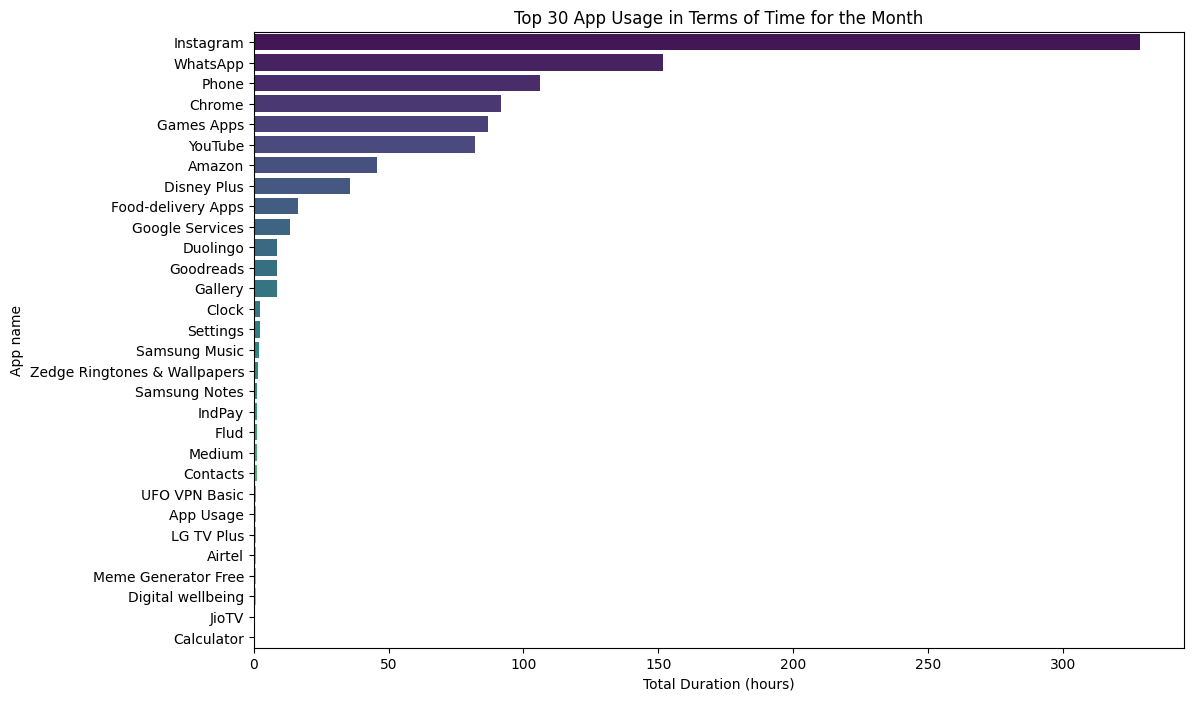

In [379]:
app_usage = df_apps.groupby('App name')['Duration'].sum().reset_index()
app_usage = app_usage.sort_values(by='Duration', ascending=False)
top_30_apps = app_usage.head(30)
top_30_apps['Duration'] = top_30_apps['Duration'] / 3600


plt.figure(figsize=(12, 8))
sns.barplot(x='Duration', y='App name', data=top_30_apps, hue='App name', palette='viridis', legend=False)
plt.xlabel('Total Duration (hours)')
plt.ylabel('App name')
plt.title('Top 30 App Usage in Terms of Time for the Month')
plt.show()

/tmp/ipykernel_8702/1220831198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_30_apps_remove_first['Duration'] = top_30_apps_remove_first['Duration'] / 3600


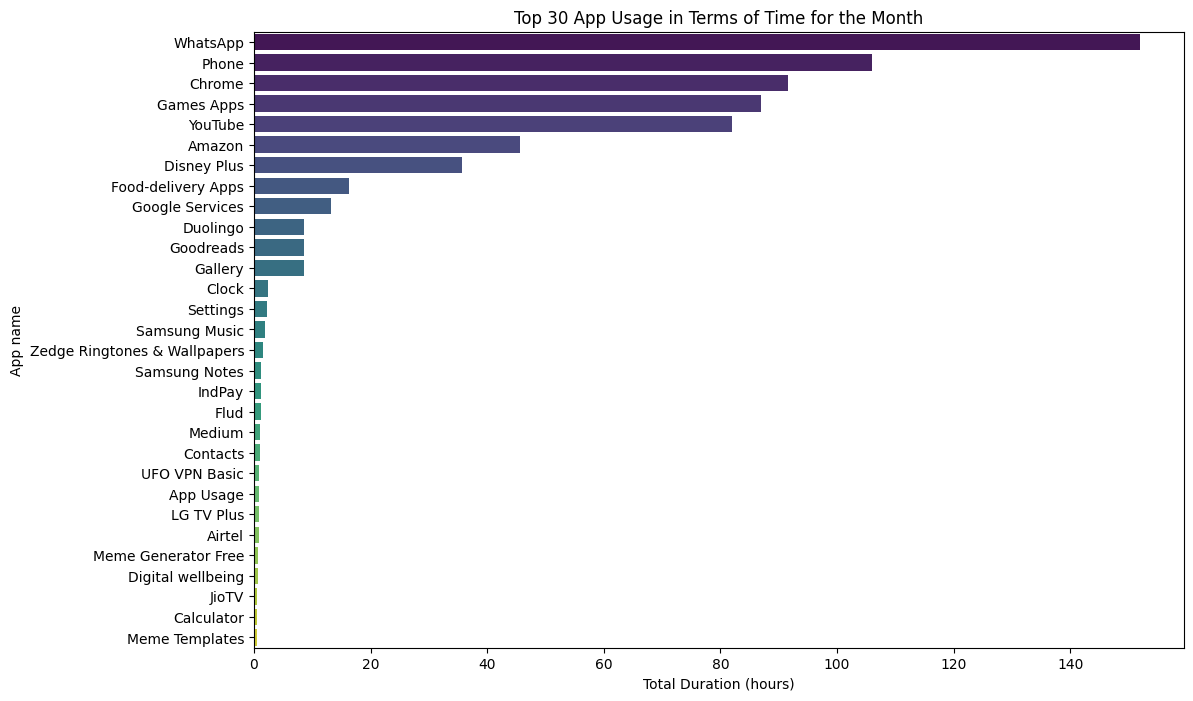

In [380]:
top_30_apps_remove_first = app_usage.iloc[1:31]
top_30_apps_remove_first['Duration'] = top_30_apps_remove_first['Duration'] / 3600


plt.figure(figsize=(12, 8))
sns.barplot(x='Duration', y='App name', data=top_30_apps_remove_first, hue='App name', palette='viridis', legend=False)
plt.xlabel('Total Duration (hours)')
plt.ylabel('App name')
plt.title('Top 30 App Usage in Terms of Time for the Month')
plt.show()

## 2.2 App Usage (Number of time opened) for the month

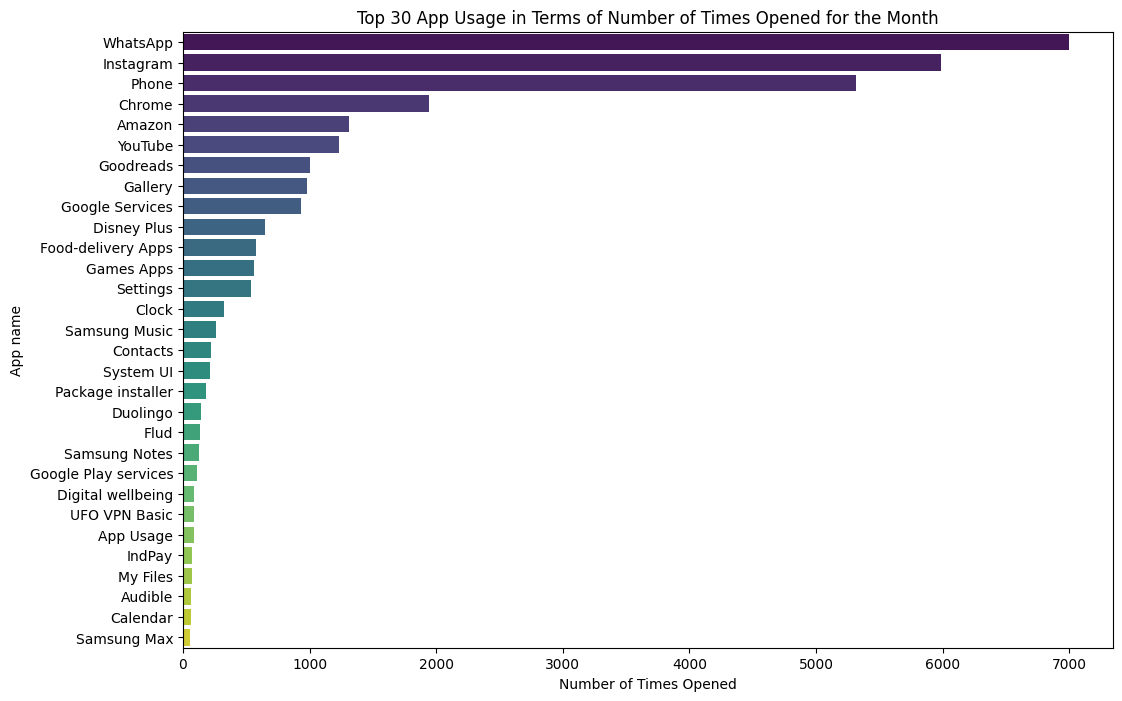

In [381]:
app_usage = df_apps.groupby('App name')['Date'].count().reset_index()
app_usage = app_usage.sort_values(by='Date', ascending=False)
top_30_apps = app_usage.head(30)

# Rename the 'Date' column to 'Count' for clarity
top_30_apps = top_30_apps.rename(columns={'Date': 'Count'})

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='App name', data=top_30_apps, hue='App name', palette='viridis', legend=False)
plt.xlabel('Number of Times Opened')
plt.ylabel('App name')
plt.title('Top 30 App Usage in Terms of Number of Times Opened for the Month')
plt.show()

# 3. Generate the data for visualization (for clusters)

In [382]:
date_to_pid = {date: pid for pid, date in enumerate(df['Date'].unique(), start=1)}
df['pid'] = df['Date'].map(date_to_pid)
df.sort_values(by=['pid', 'Time'], inplace=True)
df

,App name,Date,Time,Duration,pid
261,Chrome,2019-11-26,00:00:00,375,1
260,Screen off,2019-11-26,00:06:20,779,1
258,Screen off,2019-11-26,00:19:31,9226,1
256,Screen off,2019-11-26,02:53:27,17709,1
253,Screen off,2019-11-26,07:49:35,1570,1
...,...,...,...,...,...
90386,Chrome,2019-05-17,23:38:41,23,194
90385,WhatsApp,2019-05-17,23:39:05,418,194
90384,Screen off,2019-05-17,23:46:06,144,194
90382,Screen off,2019-05-17,23:48:41,589,194


In [383]:

### Data normalization
# 1. Add the Phone locked from midnight to the nearest applications
screen_off_df = []
for v in date_to_pid.values():
    temp_df = df[df['pid'] == v].reset_index()
    if temp_df.iloc[0]['Time'] > pd.to_datetime("00:00:00").time():
        time_diff = (temp_df.iloc[0]['Time'].hour * 3600 +
                         temp_df.iloc[0]['Time'].minute * 60 +
                         temp_df.iloc[0]['Time'].second)
        
        screen_off_df.append({
            'Date': temp_df.iloc[0]['Date'],
            'Time': pd.to_datetime('00:00:00').time(),
            'App name': 'Screen off',
            'pid': v,
            'Duration': time_diff
        })

screen_off_df = pd.DataFrame(screen_off_df)


df = pd.concat([df, screen_off_df])
df.sort_values(by=['pid', 'Time'], inplace=True)
df = df.reset_index()

#Conver to minutes
df['Duration'] = df['Duration'] / 60

# 15 most used apps (duration) (I create others so that we could put other applications in)
top_apps = df['App name'].value_counts().nlargest(14).index.tolist()
df['grp'] = df['App name'].apply(lambda x: x if x in top_apps else 'Others')


# 2. Sorting the pid by time for each day

result_df = df[['pid', 'Date', 'grp', 'Duration']].copy()
result_df = result_df[['pid', 'Date', 'grp', 'Duration']]

# 3. Make the duration to int, eliminate too short periods
result_df['Duration'] = result_df['Duration'].astype('int')
result_df = result_df[result_df['Duration']!=0]

# 4. Change Duration to duration
result_df.rename(columns={"Duration": "duration"}, inplace=True)

result_df.reset_index()
result_df.head(5)

,pid,Date,grp,duration
0,1,2019-11-26,Chrome,6
1,1,2019-11-26,Screen off,12
2,1,2019-11-26,Screen off,153
3,1,2019-11-26,Screen off,295
4,1,2019-11-26,Screen off,26


In [384]:
result_df.to_csv('data/VietAnh_processed_data.csv') 

## 4. Heat map of application usage (opened time)

/tmp/ipykernel_8702/979794391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_20['Time'] = pd.to_datetime(df_top_20['Time'], format='%H:%M:%S').dt.time
/tmp/ipykernel_8702/979794391.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_top_20['Time_15min'] = pd.to_datetime(df_top_20['Time'].astype(str)).dt.round('15min').dt.time
/tmp/ipykernel_8702/979794391.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

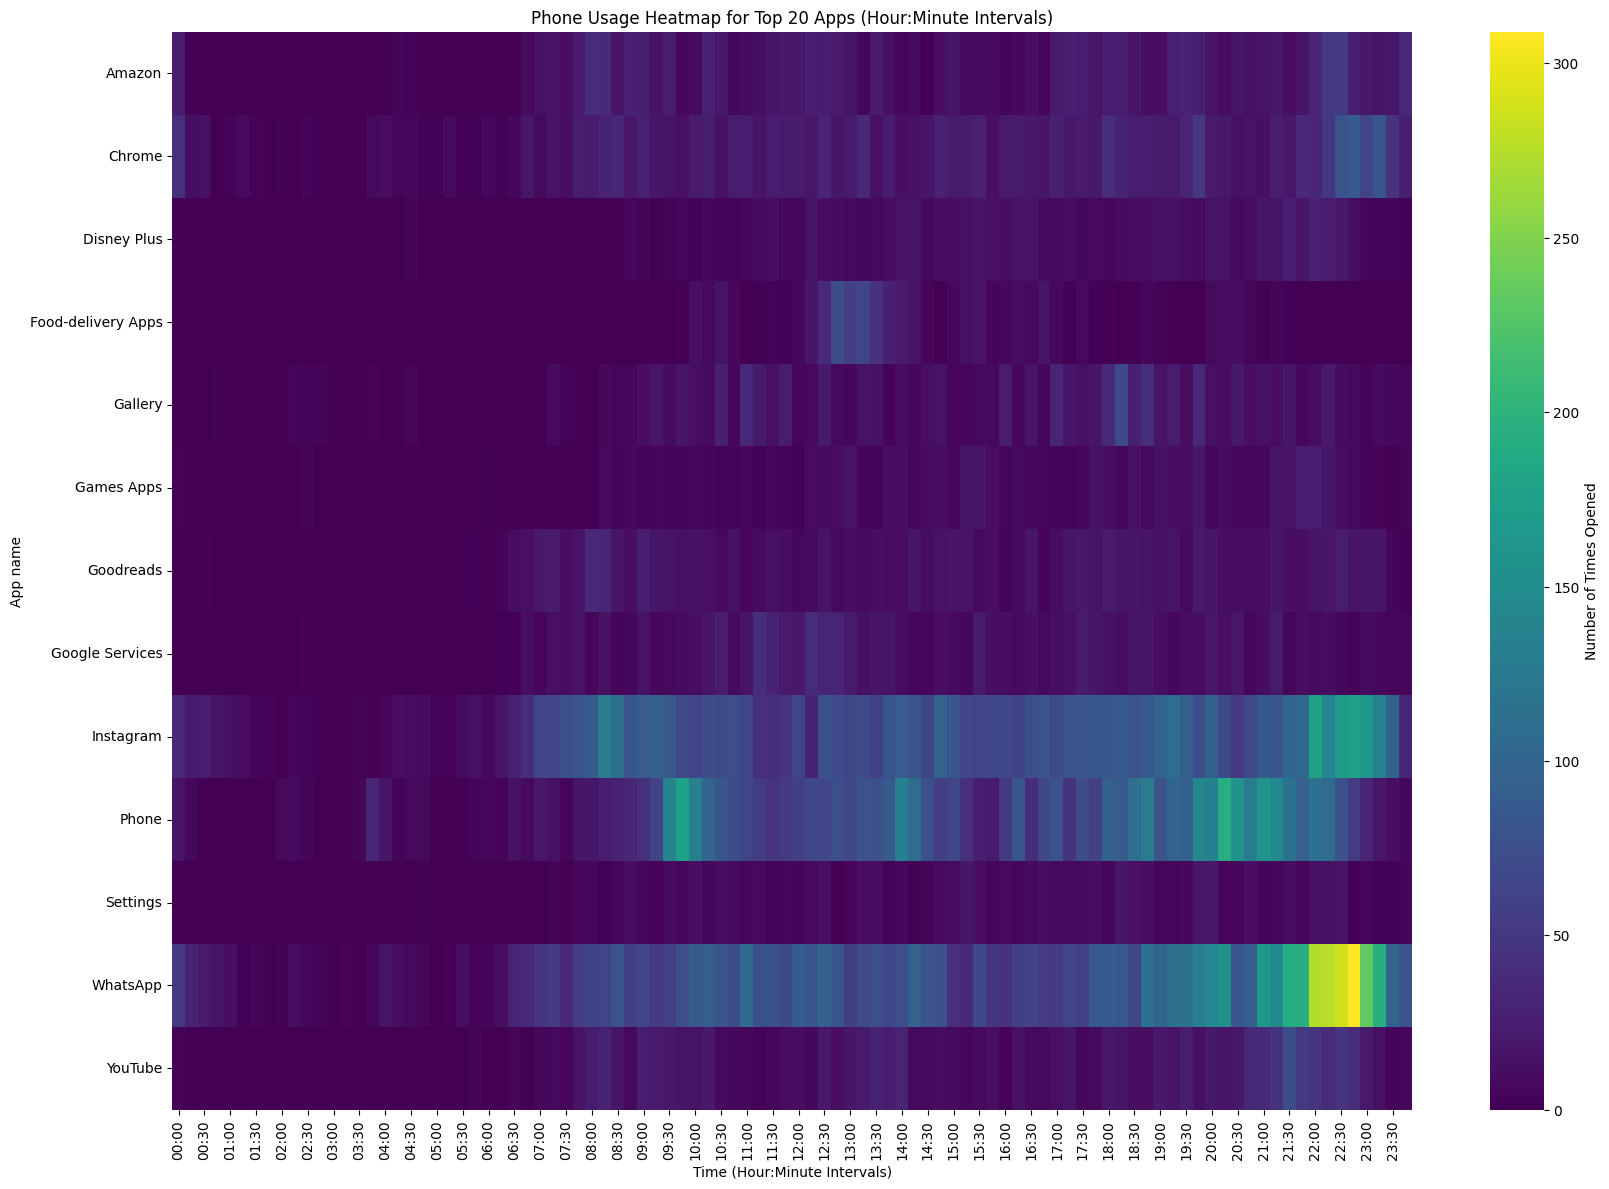

In [385]:
top_20_apps = result_df.groupby('grp')['duration'].sum().nlargest(20).index
df_top_20 = df_apps[df_apps['App name'].isin(top_20_apps)]


df_top_20['Time'] = pd.to_datetime(df_top_20['Time'], format='%H:%M:%S').dt.time
df_top_20['Time_15min'] = pd.to_datetime(df_top_20['Time'].astype(str)).dt.round('15min').dt.time

# Now you can convert 'Time_15min' to the desired string format
df_top_20['Time_15min'] = df_top_20['Time_15min'].astype(str).str[-8:-3]


all_hours = pd.date_range(start="00:00", end="23:59", freq="15min").strftime('%H:%M')
df_top_20_pivot = df_top_20.pivot_table(index='App name', columns='Time_15min', aggfunc='size', fill_value=0)
df_top_20_pivot = df_top_20_pivot.reindex(columns=all_hours, fill_value=0)

plt.figure(figsize=(20, 14))
sns.heatmap(df_top_20_pivot, cmap='viridis', cbar_kws={'label': 'Number of Times Opened'}, annot=False, fmt='g')
plt.xlabel('Time (Hour:Minute Intervals)')
plt.ylabel('App name')
plt.title('Phone Usage Heatmap for Top 20 Apps (Hour:Minute Intervals)')
plt.show()

In [386]:
df_top_20_pivot.to_csv('data/static_visualization.csv')